## 🚗 Car Model Classification with Deep Learning

#### 1. Import Libraries

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#### 2. Data Preparation


In [65]:
train_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(15),
  transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
  transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456, 0.406],
                       std=[0.229,0.224, 0.225])
])

test_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                       std=[0.229,0.224,0.225])
])

#### Load Datasets

In [66]:
train_dir = "./dataset/train"
val_dir = "./dataset/val"
test_dir = "./dataset/val"

In [ ]:
# 1. Training Dataset
train_data = datasets.ImageFolder(train_dir, transform=train_transform)

# 2. Validation Dataset 
val_data = datasets.ImageFolder(test_dir, transform=test_transform)

# 3. Test Dataset
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [68]:
train_data

Dataset ImageFolder
    Number of datapoints: 392
    Root location: ./dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=None)
               RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [69]:
class_names = train_data.classes
class_names

['Maruti_Suzuki_Baleno',
 'Maruti_Suzuki_Brezza',
 'Maruti_Suzuki_Swift',
 'Maruti_Suzuki_WagonR']

#### Create DataLoaders

In [70]:
BATCH_SIZE = 32

In [134]:
# 1. Training DataLoader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# 2. Validation DataLoader
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# 3. Test DataLoader
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

#### 3. Model Setup

In [ ]:
# 1. Get pre-trained weights
weights = models.EfficientNet_B0_Weights.DEFAULT

# 2. Load model with those weights and move to device
model = models.efficientnet_b0(weights=weights).to(device)

In [73]:
# !pip install torchinfo

In [74]:
from torchinfo import summary

In [75]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape         Output Shape        Param #             Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]   [32, 1000]          --                  True
├─Sequential (features)                                      [32, 3, 224, 224]   [32, 1280, 7, 7]    --                  True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]   [32, 32, 112, 112]  --                  True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]   [32, 32, 112, 112]  864                 True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]  [32, 32, 112, 112]  64                  True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]  [32, 32, 112, 112]  --                  --
│    └─Sequential (1)                                        [32, 32, 112, 112]  [32, 16, 112, 112]  --            

#### Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the features section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with requires_grad=False is "untrainable" or "frozen" in place.

In [76]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for parms in model.features.parameters():
  parms.requires_grad = False

In [77]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape         Output Shape        Param #             Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]   [32, 1000]          --                  Partial
├─Sequential (features)                                      [32, 3, 224, 224]   [32, 1280, 7, 7]    --                  False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]   [32, 32, 112, 112]  --                  False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]   [32, 32, 112, 112]  (864)               False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]  [32, 32, 112, 112]  (64)                False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]  [32, 32, 112, 112]  --                  --
│    └─Sequential (1)                                        [32, 32, 112, 112]  [32, 16, 112, 112]  --     

In [78]:
# Unfreeze last 2 blocks for fine-tuning
for param in model.features[-2:].parameters():
    param.requires_grad = True

In [79]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape         Output Shape        Param #             Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]   [32, 1000]          --                  Partial
├─Sequential (features)                                      [32, 3, 224, 224]   [32, 1280, 7, 7]    --                  Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]   [32, 32, 112, 112]  --                  False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]   [32, 32, 112, 112]  (864)               False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]  [32, 32, 112, 112]  (64)                False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]  [32, 32, 112, 112]  --                  --
│    └─Sequential (1)                                        [32, 32, 112, 112]  [32, 16, 112, 112]  --   

In [80]:
output_shape = len(class_names)

In [ ]:
# Custom classifier with  dropout
model.classifier = nn.Sequential(
  nn.Dropout(p=0.5, inplace=True),
  nn.Linear(in_features=1280,
            out_features=output_shape,
            bias=True)
).to(device)

#### 4. Training Components

In [82]:
LEARNING_RATE = 0.001

In [ ]:
# 1. Loss Function
loss_fn = nn.CrossEntropyLoss()

# 2. Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# 3. Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.5) 

#### Implement Early Stopping

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0.001):
    self.patience = patience      # How many epochs to wait before stopping
    self.min_delta = min_delta    # Minimum improvement threshold
    self.counter = 0              # Count epochs without improvement
    self.best_loss = None         # Track the best validation loss seen
    self.early_stop = False       # Flag to indicate when to stop training


  def __call__(self, val_loss):
    if self.best_loss is None:
        # First epoch - initialize best loss
        self.best_loss = val_loss
        
    elif val_loss < self.best_loss - self.min_delta:
        # Significant improvement found
        self.best_loss = val_loss
        self.counter = 0  # Reset patience counter
        
    else:
        # No significant improvement
        self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True  # Trigger early stopping


#### 5. Training Functions

#### Train Step
train_step is a single training epoch step function used to train your neural network model for one complete pass over the training dataset.

In [85]:
def train_step(model, dataloader, loss_fn, optimizer, device):
  # 1. Set the model to "training" mode
  model.train()

  # 2. Initialize loss and accuracy counters
  train_loss, train_acc = 0, 0

  # 3. Loop over each batch in the training DataLoader
  for X, y in dataloader:
    # 4. Send data to GPU or CPU
    X,y = X.to(device), y.to(device)

    # 5. Clear previous gradients
    optimizer.zero_grad()

    # 6. Forward pass: model computes predictions
    y_pred = model(X)

    # 7. Calculate loss between predictions and true labels
    loss = loss_fn(y_pred, y)

    # 8. Backward pass: compute gradients
    loss.backward()

    # 9. Update model weights using optimizer
    optimizer.step()

    # 10. Accumulate batch loss
    train_loss += loss.item()

    # 11. Calculate accuracy for the batch (predicted label == actual label)
    train_acc += (torch.argmax(y_pred, dim=1) == y).sum().item() / len(y)

  # 12. Return average loss and accuracy per batch for the epoch
  return train_loss / len(dataloader), train_acc / len(dataloader)

#### Test Step
test_step evaluates your trained model on validation or test data without updating the model parameters. It's used to measure how well your model performs on unseen data during training or final evaluation1

In [86]:
def test_step(model, dataloader, loss_fn, device):
  
  # 1. Set model to "evaluation" mode
  model.eval()

  # 2. Initialize loss and accuracy counters
  test_loss, test_acc = 0, 0

  # 3. Disable gradient computation for efficiency
  with torch.inference_mode():
    # 4. Loop through validation/test batches
    for X, y in dataloader:

      # 5. Move data to device(GPU) 
      X, y= X.to(device), y.to(device)

      # 6. Forward pass only (no backprop)
      y_pred = model(X)

      # 7. Accumulate loss
      test_loss += loss_fn(y_pred, y).item()

      # 8. Calculate and accumulate accuracy
      test_acc += (torch.argmax(y_pred, dim=1) == y).sum().item() / len(y)
    
  # 9. Return average metrics
  return test_loss/ len(dataloader), test_acc / len(dataloader)

### Train

The train function is the master training loop that orchestrates the entire training process by combining all the individual components (train_step, test_step, early stopping, etc.)

The train function is the complete training orchestrator that:

- Runs multiple training epochs

- Tracks training and validation metrics

- Implements learning rate scheduling

- Handles early stopping

- Provides progress monitoring

In [87]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs, device, early_stopping, scheduler):

  # 1. Initialize results dictionary to store metrics
  results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

  # 2. Main training loop with progress bar
  for epoch in tqdm(range(epochs), desc="Training"):

    # 3. Train for one epoch
    train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)

    # 4. Evaluate on validation set
    val_loss, val_acc = test_step(model, val_loader, loss_fn, device)

    # 5. Display epoch results
    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | " 
          f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")
    
    # 6. Store metrics for later analysis
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["val_loss"].append(val_loss)
    results["val_acc"].append(val_acc)

    # 7. Update learning rate based on validation loss
    scheduler.step(val_loss)

    # 8. Check early stopping condition
    early_stopping(val_loss)
    if early_stopping.early_stop:
      print(f"Early stopping at epoch {epoch+1}")
      break

  # 9. Return all collected metrics
  return results

#### 6. Visualization Function

In [88]:
def plot_metrics(results):
    # 1. Create epoch numbers for x-axis
    epochs = range(1, len(results['train_loss']) + 1)
    
    # 2. Create figure with specified size
    plt.figure(figsize=(12, 4))
    
    # 3. First subplot - Loss curves
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
    plt.plot(epochs, results['train_loss'], label='Train Loss')
    plt.plot(epochs, results['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # 4. Second subplot - Accuracy curves
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
    plt.plot(epochs, results['train_acc'], label='Train Accuracy')
    plt.plot(epochs, results['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # 5. Format and display
    plt.tight_layout()  # Automatically adjust spacing
    plt.show()

#### 7. Main Execution


Training:   2%|▏         | 1/50 [00:13<10:43, 13.13s/it]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.5385 | val_loss: 0.8059 | val_acc: 0.7188


Training:   4%|▍         | 2/50 [00:24<09:42, 12.14s/it]

Epoch: 2 | train_loss: 0.5640 | train_acc: 0.8197 | val_loss: 0.3334 | val_acc: 0.8679


Training:   6%|▌         | 3/50 [00:36<09:17, 11.86s/it]

Epoch: 3 | train_loss: 0.3016 | train_acc: 0.8966 | val_loss: 0.2394 | val_acc: 0.9167


Training:   8%|▊         | 4/50 [00:47<08:59, 11.73s/it]

Epoch: 4 | train_loss: 0.2375 | train_acc: 0.9351 | val_loss: 0.2437 | val_acc: 0.8991


Training:  10%|█         | 5/50 [00:56<08:01, 10.71s/it]

Epoch: 5 | train_loss: 0.1373 | train_acc: 0.9639 | val_loss: 0.2621 | val_acc: 0.8849


Training:  12%|█▏        | 6/50 [01:01<06:26,  8.78s/it]

Epoch: 6 | train_loss: 0.1025 | train_acc: 0.9615 | val_loss: 0.2245 | val_acc: 0.9200


Training:  14%|█▍        | 7/50 [01:10<06:25,  8.96s/it]

Epoch: 7 | train_loss: 0.1008 | train_acc: 0.9712 | val_loss: 0.2983 | val_acc: 0.8991


Training:  16%|█▌        | 8/50 [01:20<06:20,  9.05s/it]

Epoch: 8 | train_loss: 0.0834 | train_acc: 0.9784 | val_loss: 0.2495 | val_acc: 0.9200


Training:  18%|█▊        | 9/50 [01:29<06:17,  9.20s/it]

Epoch: 9 | train_loss: 0.0656 | train_acc: 0.9832 | val_loss: 0.2219 | val_acc: 0.9095


Training:  20%|██        | 10/50 [01:38<06:07,  9.19s/it]

Epoch: 10 | train_loss: 0.0435 | train_acc: 0.9880 | val_loss: 0.1757 | val_acc: 0.9200


Training:  22%|██▏       | 11/50 [01:48<05:59,  9.22s/it]

Epoch: 11 | train_loss: 0.0520 | train_acc: 0.9904 | val_loss: 0.2337 | val_acc: 0.9095


Training:  24%|██▍       | 12/50 [01:57<05:52,  9.27s/it]

Epoch: 12 | train_loss: 0.0380 | train_acc: 0.9904 | val_loss: 0.2870 | val_acc: 0.9304


Training:  26%|██▌       | 13/50 [02:06<05:44,  9.31s/it]

Epoch: 13 | train_loss: 0.0630 | train_acc: 0.9760 | val_loss: 0.3296 | val_acc: 0.9200


Training:  28%|██▊       | 14/50 [02:16<05:33,  9.26s/it]

Epoch: 14 | train_loss: 0.0435 | train_acc: 0.9880 | val_loss: 0.2787 | val_acc: 0.9408


Training:  28%|██▊       | 14/50 [02:25<06:13, 10.37s/it]

Epoch: 15 | train_loss: 0.0619 | train_acc: 0.9856 | val_loss: 0.2385 | val_acc: 0.9408
Early stopping at epoch 15


Test Loss: 0.2385 | Test Accuracy: 0.9408


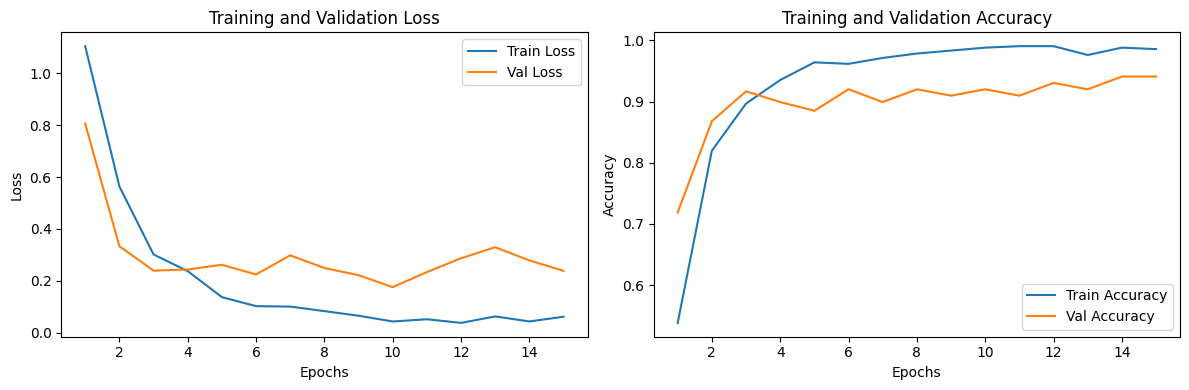

In [89]:
EPOCHS = 50

if __name__ == "__main__":
    # 1. Create early stopping object with increased patience
    early_stopper = EarlyStopping(patience=5, min_delta=0.001)  # Increased patience

    # 2. Execute the complete training process
    results = train(model, train_dataloader, val_dataloader, optimizer, loss_fn, EPOCHS, device, early_stopper, scheduler)
    
    # 3. Final evaluation on test set
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    
    # 4. Visualize training progress
    plot_metrics(results)

#### Make predictions on images from the test set

In [100]:
from typing import List, Tuple
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def predict_and_show_image(model: torch.nn.Module,
                          image_path: str, 
                          class_names: List[str],
                          device: torch.device,
                          image_size: Tuple[int, int] = (224, 224)):
    """
    Make prediction on a single image and display the result
    
    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        class_names: List of class names (e.g., ['swift', 'brezza', 'baleno', 'wagonr'])
        device: Device to run inference on (CPU or GPU)
        image_size: Size to resize image to (default: 224x224)
    """
    
    # Step 1: Load the image
    image = Image.open(image_path)
    # print(f"Loaded image from: {image_path}")
    
    # Step 2: Define image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Step 3: Preprocess the image
    input_image = preprocess(image)
    input_batch = input_image.unsqueeze(0)  # Add batch dimension [1, 3, 224, 224]
    
    # Step 4: Make prediction
    model.eval()  # Set model to evaluation mode
    model.to(device)
    
    with torch.no_grad():  # Disable gradient computation for faster inference
        input_batch = input_batch.to(device)
        
        # Get model predictions (raw logits)
        predictions = model(input_batch)
        
        # Convert to probabilities
        probabilities = torch.softmax(predictions, dim=1)
        
        # Get the predicted class and confidence
        confidence, predicted_class = torch.max(probabilities, 1)
        
    # Step 5: Extract results
    predicted_label = class_names[predicted_class.item()]
    confidence_score = confidence.item()
    
    # Step 6: Display results
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence_score:.3f}", 
              fontsize=14, fontweight='bold')
    plt.axis('off')  # Hide axes for cleaner look
    plt.tight_layout()
    plt.show()
    
    # Step 7: Print results to console
    # print(f"Predicted Class: {predicted_label}")
    # print(f"Confidence Score: {confidence_score:.3f}")
    
    return predicted_label, confidence_score


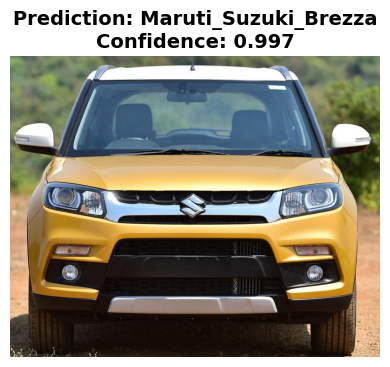

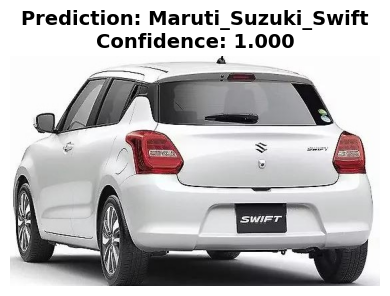

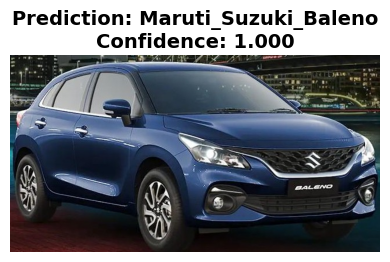

In [104]:
# Get a random list of image paths from test set
import random
test_dir = "./dataset/test"
class_names = train_data.classes

from pathlib import Path
num_images_to_plot = 3

# 1. Get all test image paths
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))

# 2. Randomly sample images for prediction
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# 3. Make predictions and display results
for image_path in test_image_path_sample:
    predict_and_show_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224),
                        device=device)

#### Save Trained Model

In [105]:
import torch
import pickle
import json
from datetime import datetime
import os

def save_complete_model(model, results, class_names, save_dir="./saved_models"):
    """
    Save the complete model package for deployment
    """
    # Create save directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Get current timestamp for version control
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"car_classifier_{timestamp}"
    
    # 1. Save model state dict (recommended for PyTorch)
    model_path = os.path.join(save_dir, f"{model_name}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"✅ Model weights saved: {model_path}")
    
    # 2. Save complete model (alternative method)
    full_model_path = os.path.join(save_dir, f"{model_name}_full.pth")
    torch.save(model, full_model_path)
    print(f"✅ Full model saved: {full_model_path}")
    
    # 3. Save training results
    results_path = os.path.join(save_dir, f"{model_name}_results.pkl")
    with open(results_path, 'wb') as f:
        pickle.dump(results, f)
    print(f"✅ Training results saved: {results_path}")
    
    # 4. Save model metadata
    metadata = {
        "model_name": model_name,
        "timestamp": timestamp,
        "class_names": class_names,
        "num_classes": len(class_names),
        "input_size": [224, 224],
        "architecture": "EfficientNet-B0",
        "final_test_accuracy": max(results['val_acc']),
        "total_epochs": len(results['train_loss']),
        "normalization_mean": [0.485, 0.456, 0.406],
        "normalization_std": [0.229, 0.224, 0.225]
    }
    
    metadata_path = os.path.join(save_dir, f"{model_name}_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✅ Metadata saved: {metadata_path}")
    
    return {
        "model_path": model_path,
        "full_model_path": full_model_path, 
        "results_path": results_path,
        "metadata_path": metadata_path,
        "model_name": model_name
    }

# Execute the save function after training
if __name__ == "__main__":
    # After your training is complete
    saved_paths = save_complete_model(
        model=model,
        results=results,
        class_names=class_names
    )
    
    print(f"\n🎉 Model package saved successfully!")
    print(f"📦 Model name: {saved_paths['model_name']}")


✅ Model weights saved: ./saved_models\car_classifier_20250730_223615.pth
✅ Full model saved: ./saved_models\car_classifier_20250730_223615_full.pth
✅ Training results saved: ./saved_models\car_classifier_20250730_223615_results.pkl
✅ Metadata saved: ./saved_models\car_classifier_20250730_223615_metadata.json

🎉 Model package saved successfully!
📦 Model name: car_classifier_20250730_223615


#### Load Save Model

In [107]:
import torch
import torchvision
import json
from typing import Dict, Any

def load_model_for_inference(model_path: str, metadata_path: str, device: str = "cpu"):
    """
    Load saved model for inference
    """
    # Load metadata
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Recreate model architecture
    model = torchvision.models.efficientnet_b0(weights=None)
    
    # Recreate classifier
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(1280, metadata['num_classes'])
    )
    
    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)
    
    print(f"✅ Model loaded successfully!")
    print(f"📊 Classes: {metadata['class_names']}")
    print(f"🎯 Test Accuracy: {metadata['final_test_accuracy']:.4f}")
    
    return model, metadata

# Test the loader
model_loaded, metadata = load_model_for_inference(
    model_path="./saved_models/car_classifier_20250730_223615.pth",
    metadata_path="./saved_models/car_classifier_20250730_223615_metadata.json"
)


✅ Model loaded successfully!
📊 Classes: ['Maruti_Suzuki_Baleno', 'Maruti_Suzuki_Brezza', 'Maruti_Suzuki_Swift', 'Maruti_Suzuki_WagonR']
🎯 Test Accuracy: 0.9408


C:\Users\mistr\AppData\Local\Temp\ipykernel_14232\2436551115.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

#### Make Prediction Using Save Model

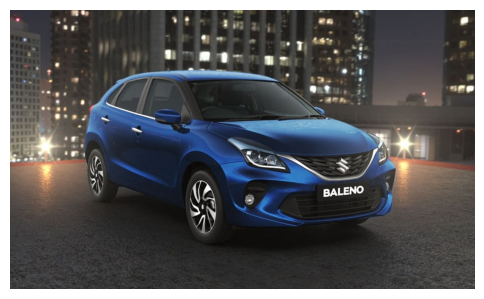

🚗 Predicted Car Model: Maruti_Suzuki_Baleno
🎯 Confidence: 1.000 (100.0%)


In [132]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, metadata, device):
    """
    Simple prediction function that shows image, predicted class and confidence
    
    Args:
        model: Loaded PyTorch model
        image_path: Path to the image file
        metadata: Model metadata containing class names
        device: Device to run inference on
    
    Returns:
        Dictionary with prediction results
    """
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Preprocess image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
    
    # Get results
    predicted_class = metadata['class_names'][predicted_idx.item()]
    confidence_score = confidence.item()
    
    # Show image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    # plt.title(f"Predicted: {predicted_class} | Confidence: {confidence_score:.3f}", 
    #           fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Return simple results
    return {
        'predicted_class': predicted_class,
        'confidence': confidence_score
    }

# Usage
image_path = "./Test_image_sample/baleno2.jpg"
prediction = predict_single_image(model, image_path, metadata, device)

print(f"🚗 Predicted Car Model: {prediction['predicted_class']}")
print(f"🎯 Confidence: {prediction['confidence']:.3f} ({prediction['confidence']*100:.1f}%)")


#### Check The Size of Your Saved Model Files

In [136]:
import os

def check_model_size(model_path):
    """
    Check the size of your saved model file
    
    Args:
        model_path: Path to your saved model file
    
    Returns:
        File size in bytes, KB, and MB
    """
    try:
        # Get file size in bytes
        size_bytes = os.path.getsize(model_path)
        
        # Convert to KB and MB
        size_kb = size_bytes / 1024
        size_mb = size_kb / 1024
        
        print(f"📁 Model File: {os.path.basename(model_path)}")
        print(f"📊 Size: {size_bytes:,} bytes")
        print(f"📊 Size: {size_kb:.2f} KB")
        print(f"📊 Size: {size_mb:.2f} MB")
        
        return size_bytes, size_kb, size_mb
        
    except FileNotFoundError:
        print(f"❌ File not found: {model_path}")
        return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Check your saved model
model_path = "./saved_models/car_classifier_20250730_223615_full.pth"
check_model_size(model_path)


📁 Model File: car_classifier_20250730_223615_full.pth
📊 Size: 16,414,962 bytes
📊 Size: 16030.24 KB
📊 Size: 15.65 MB


(16414962, 16030.236328125, 15.65452766418457)

#### Check All Saved Model Files

In [137]:
import os
from pathlib import Path

def check_all_model_files(saved_models_dir="./saved_models"):
    """
    Check sizes of all saved model files in directory
    """
    try:
        model_dir = Path(saved_models_dir)
        
        if not model_dir.exists():
            print(f"❌ Directory not found: {saved_models_dir}")
            return
        
        print(f"🔍 Checking models in: {saved_models_dir}")
        print("-" * 60)
        
        # Find all model files
        model_files = list(model_dir.glob("*.pth")) + list(model_dir.glob("*.pkl")) + list(model_dir.glob("*.json"))
        
        if not model_files:
            print("❌ No model files found in directory")
            return
        
        total_size = 0
        
        for file_path in sorted(model_files):
            try:
                size_bytes = file_path.stat().st_size
                size_mb = size_bytes / (1024 * 1024)
                total_size += size_bytes
                
                print(f"📄 {file_path.name}")
                print(f"   Size: {size_bytes:,} bytes ({size_mb:.2f} MB)")
                print()
                
            except Exception as e:
                print(f"❌ Error reading {file_path.name}: {e}")
        
        print("-" * 60)
        print(f"📦 Total size: {total_size:,} bytes ({total_size/(1024*1024):.2f} MB)")
        
    except Exception as e:
        print(f"❌ Error: {e}")

# Check all your saved models
check_all_model_files()


🔍 Checking models in: ./saved_models
------------------------------------------------------------
📄 car_classifier_20250730_223615.pth
   Size: 16,357,462 bytes (15.60 MB)

📄 car_classifier_20250730_223615_full.pth
   Size: 16,414,962 bytes (15.65 MB)

📄 car_classifier_20250730_223615_metadata.json
   Size: 612 bytes (0.00 MB)

📄 car_classifier_20250730_223615_results.pkl
   Size: 618 bytes (0.00 MB)

------------------------------------------------------------
📦 Total size: 32,773,654 bytes (31.26 MB)
